# MODEL IMPLEMENTATION
This notebook presents the implementation and training process of a series of machine learning models based on **Neural Networks**.

However, this type of networks configuration (a standard *multi-label classification* problem) did not lead to satisfactory performance. For this reason, we later focused on developing a **One-vs-All** approach instead (see the "*NN model per label* " notebook).


In [ ]:
# Install tfa with tf compatibility
!pip install tensorflow-addons[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: typeguard
    Found existing inst

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC, Precision, Recall, F1Score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                             precision_score,
                             recall_score,
                             accuracy_score,
                             f1_score,
                             balanced_accuracy_score,
                             average_precision_score,
                             roc_auc_score, matthews_corrcoef,
                             confusion_matrix, hamming_loss)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow.keras.models import load_model, clone_model
import joblib

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Set Pandas to display all columns
pd.set_option('display.max_columns', None)

# Utility functions


## Data preparation

In [ ]:
def prepare_data_for_model(folder_path, filenames_dict, target_cols, continuous_cols, batch_size, dropped_cols=None, model_name="model"):
    """
    Loads, scales, and prepares data into TensorFlow Datasets.

    Args:
        folder_path (str): Path to the folder containing the TSV files.
        filenames_dict (dict): Dictionary with keys 'train', 'test', 'val'
                                and values as the corresponding filenames.
        target_cols (list): List of target column names.
        continuous_cols (list): List of names of columns to be scaled.
        batch_size (int): Batch size for the TensorFlow Datasets.
        dropped_cols (list, optional): List of columns to drop. Defaults to None.
        model_name (str, optional): Name of the model to use for saving the scaler. Defaults to "model".

    Returns:
        tuple: A tuple containing the prepared train, val, and test TensorFlow Datasets.
    """

    def load_tsv_as_df(folder, filename):
        if not filename.endswith('.tsv'):
            filename += '.tsv'
        path = os.path.join(folder, filename)
        df = pd.read_csv(path, sep='\t')
        return df

    # Load dataframes
    train_df = load_tsv_as_df(folder_path, filenames_dict['train'])
    test_df = load_tsv_as_df(folder_path, filenames_dict['test'])
    val_df = load_tsv_as_df(folder_path, filenames_dict['val'])

    # Drop columns (if not None)
    if dropped_cols is not None:
        train_df = train_df.drop(columns=dropped_cols)
        test_df = test_df.drop(columns=dropped_cols)
        val_df = val_df.drop(columns=dropped_cols)

    # Separate features and target
    X_train = train_df.drop(columns=target_cols)
    y_train = train_df[target_cols]

    X_test = test_df.drop(columns=target_cols)
    y_test = test_df[target_cols]

    X_val = val_df.drop(columns=target_cols)
    y_val = val_df[target_cols]

    # Ensure 'same_chain' is 0/1
    for df in [X_train, X_val, X_test]:
        if 'same_chain' in df.columns:
          df['same_chain'] = df['same_chain'].astype(int)


    # Scale continuous columns
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
    X_val_scaled[continuous_cols] = scaler.transform(X_val[continuous_cols])
    X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

    # Save the scaler
    scaler_filename = os.path.join(folder_path, f"{model_name}_scaler.pkl")
    joblib.dump(scaler, scaler_filename)
    print(f"Scaler saved to: {scaler_filename}")

    # Create TensorFlow Datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(X_train_scaled.values, dtype=tf.float32),
        tf.convert_to_tensor(y_train.values, dtype=tf.float32)
    ))

    test_dataset = tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(X_test_scaled.values, dtype=tf.float32),
        tf.convert_to_tensor(y_test.values, dtype=tf.float32)
    ))

    val_dataset = tf.data.Dataset.from_tensor_slices((
        tf.convert_to_tensor(X_val_scaled.values, dtype=tf.float32),
        tf.convert_to_tensor(y_val.values, dtype=tf.float32)
    ))

    # Shuffle, batch, prefetch
    train_dataset = train_dataset.shuffle(True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Return values
    n_features = X_train.shape[1]
    n_labels = y_train.shape[1]
    print(f"Number of features: {n_features}")
    print(f"Number of labels: {n_labels}")

    return train_dataset, val_dataset, test_dataset, n_features, n_labels, y_val, y_test

## Threshold computation
Given the poor performance of the network, applying a threshold was merely a rough experiment.

In particular, the following function is used to extract an optimal threshold to filter sigmoid values in a label-specific fashion.

The threshold is identified, with a grid search, maximizing a classification metric in the **validation set**, F1 score by default.

In [ ]:
def compute_best_thresholds(model, val_dataset, target_cols, metric):
    """
    Computes and prints the best per-label thresholds based on a given metric.

    Args:
        model (tf.keras.Model): The trained model.
        val_dataset (tf.data.Dataset): The validation dataset.
        target_cols (list): List of target column names.
        metric (function): The metric function to use for threshold selection.
    """
    y_pred_val = []
    y_true_val = []

    for batch_x, batch_y in val_dataset:
        preds = model.predict(batch_x, verbose=0)
        y_pred_val.append(preds)
        y_true_val.append(batch_y.numpy())

    y_pred_val_array = np.vstack(y_pred_val)
    y_true_val_array = np.vstack(y_true_val)

    thresholds = []
    threshold_values = np.arange(0.05, 0.95, 0.05)

    for i in range(y_true_val_array.shape[1]):
        best_thresh = 0.5
        best_score = 0

        for t in threshold_values:
            y_pred_bin = (y_pred_val_array[:, i] >= t).astype(int)
            score = metric(y_true_val_array[:, i], y_pred_bin, zero_division=0)

            if score > best_score:
                best_score = score
                best_thresh = t

        thresholds.append(best_thresh)

    for label_idx, label_name in enumerate(target_cols):
        print(f"{label_name} Threshold: {thresholds[label_idx]:.4f}")

    return np.array(thresholds)

## Model evaluation


In [ ]:
def evaluate_multilabel_model(model, test_dataset, target_cols, thresholds):
    """
    Evaluates a multi-label classification model, computes metrics,
    and plots confusion matrices and co-occurrence matrix.

    Args:
        model (tf.keras.Model): The trained model.
        test_dataset (tf.data.Dataset): The test dataset.
        target_cols (list): List of target column names.
        thresholds (np.ndarray): Array of per-label thresholds.
    """
    # Step 1: Get true labels and predicted probabilities
    y_true = []
    y_pred = []

    for batch_x, batch_y in test_dataset:
        preds = model.predict(batch_x, verbose=0)
        y_true.append(batch_y.numpy())
        y_pred.append(preds)

    # Step 2: Stack predictions
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    # Step 3: Binarize predictions with the provided thresholds
    y_pred_binary = (y_pred >= thresholds).astype(int)

    # Step 4: Evaluate with sklearn and print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_binary, target_names=target_cols, zero_division=0))
    print("-" * 50)

    # Step 5: Compute and print other metrics
    def balanced_accuracy_multilabel(y_true, y_pred):
        res = []
        for i in range(y_true.shape[1]):
            b_acc = balanced_accuracy_score(y_true[:, i], y_pred[:, i])
            res.append(b_acc)
        return np.mean(res)

    def mcc_multilabel(y_true, y_pred):
        res = []
        for i in range(y_true.shape[1]):
            try:
                b_mcc = matthews_corrcoef(y_true[:, i], y_pred[:, i])
                res.append(b_mcc)
            except ValueError:
                continue
        return np.mean(res)

    metrics = {
        'F1 micro': f1_score(y_true, y_pred_binary, average='micro', zero_division=0),
        'F1 macro': f1_score(y_true, y_pred_binary, average='macro', zero_division=0),
        'Precision (macro)': precision_score(y_true, y_pred_binary, average='macro', zero_division=0),
        'AP (macro)': average_precision_score(y_true, y_pred, average='macro'),
        'Recall (macro)': recall_score(y_true, y_pred_binary, average='macro', zero_division=0),
        'ROC AUC Score (macro)': roc_auc_score(y_true, y_pred, average='macro'),
        'MCC (mean)': mcc_multilabel(y_true, y_pred_binary),
        'Accuracy': accuracy_score(y_true, y_pred_binary),
        'Balanced accuracy (mean)': balanced_accuracy_multilabel(y_true, y_pred_binary),
        'Hamming Loss': hamming_loss(y_true, y_pred_binary),
    }

    print("Numerical Metrics:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")
    print("-" * 50)

    # Step 6: Plot confusion matrix for each class
    print("Plotting Confusion Matrices for each class...")
    for i, class_name in enumerate(target_cols):
        cm = confusion_matrix(y_true[:, i], y_pred_binary[:, i])
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {class_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    print("-" * 50)

    # Step 7: Plot the co-occurrence matrix
    print("Plotting Co-occurrence Matrix...")
    num_classes = y_true.shape[1]
    cooccurrence_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(num_classes):
        for j in range(num_classes):
            cooccurrence_matrix[i, j] = np.sum((y_true[:, i] == 1) & (y_pred_binary[:, j] == 1))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cooccurrence_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_cols, yticklabels=target_cols)
    plt.title('Co-occurrence Matrix of True and Predicted Labels')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Original data

## Data loading


In [ ]:
# Set folder name
folder_data = "/content/drive/MyDrive/Structural Bioinfo PROJECT/datasets"

# Set filenames dictionary
filenames = {'train': 'train_set_origin', 'test': 'test_set_origin', 'val': 'val_set_origin'}

# Specify target columns
target_cols = ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

# Specify continuos columns
continuous_cols = [
    's_resi', 's_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
    't_resi', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5'
]

# Batch size
BATCH_SIZE = 512

# Create datasets
train_dataset, val_dataset, test_dataset, n_features, n_labels, y_val, y_test = prepare_data_for_model(
    folder_data, filenames, target_cols, continuous_cols, BATCH_SIZE, model_name="origindata_multilabel"
)


Scaler saved to: /content/drive/MyDrive/Structural Bioinfo PROJECT/datasets/origindata_multilabel_scaler.pkl
Number of features: 117
Number of labels: 7


## Model definition: Trial 1

In [ ]:
# Define the model
model = models.Sequential([
    layers.Input(shape=(n_features,)),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-2)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-2)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=1e-2)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(n_labels, activation='sigmoid')  # multilabel output
])

# Compile
model.compile(
    optimizer='adam',
    loss=SigmoidFocalCrossEntropy(gamma=1.0, alpha=0.25, reduction='sum_over_batch_size'),  # tune gamma, alpha
    metrics=[
        'binary_accuracy',  # Better for multilabel: thresholded per label
        F1Score(name='f1_score'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='AUC'),
    ]
)

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=3,
                                 min_lr=1e-6)

## Training and testing

In [ ]:
# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler],
    shuffle=True
)

Epoch 1/15
1770/1770 [==============================] - 32s 16ms/step - loss: 0.5735 - binary_accuracy: 0.8545 - f1_score: 0.2233 - precision: 0.7220 - recall: 0.3456 - AUC: 0.9315 - val_loss: 0.3098 - val_binary_accuracy: 0.8587 - val_f1_score: 0.1683 - val_precision: 0.8332 - val_recall: 0.2962 - val_AUC: 0.9540 - lr: 0.0010
Epoch 2/15
1770/1770 [==============================] - 28s 16ms/step - loss: 0.3103 - binary_accuracy: 0.8662 - f1_score: 0.2536 - precision: 0.8160 - recall: 0.3566 - AUC: 0.9531 - val_loss: 0.3050 - val_binary_accuracy: 0.8645 - val_f1_score: 0.2368 - val_precision: 0.8264 - val_recall: 0.3394 - val_AUC: 0.9553 - lr: 0.0010
Epoch 3/15
1770/1770 [==============================] - 27s 15ms/step - loss: 0.3078 - binary_accuracy: 0.8663 - f1_score: 0.2593 - precision: 0.8180 - recall: 0.3554 - AUC: 0.9536 - val_loss: 0.3005 - val_binary_accuracy: 0.8655 - val_f1_score: 0.2619 - val_precision: 0.8262 - val_recall: 0.3470 - val_AUC: 0.9556 - lr: 0.0010
Epoch 4/15
17

Metrics are then computed on the test set after it is evaluated with the model.

In [ ]:
model.save(f'{folder_data}/origindata_multilabel.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Compute on test
test_loss, test_accuracy, test_f1_score, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
# Print
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"test AUC: {test_auc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
for label_idx, label_name in enumerate(target_cols):
    print(f"{label_name} F1 Score: {test_f1_score[label_idx]:.4f}")

540/540 [==============================] - 2s 4ms/step - loss: 0.2913 - binary_accuracy: 0.8681 - f1_score: 0.2805 - precision: 0.8301 - recall: 0.3594 - AUC: 0.9569
Test Loss: 0.2913
Test Accuracy: 0.8681
Test Precision: 0.8301
test AUC: 0.9569
Test Recall: 0.3594
HBOND F1 Score: 0.8425
IONIC F1 Score: 0.0000
PICATION F1 Score: 0.0000
PIHBOND F1 Score: 0.0000
PIPISTACK F1 Score: 0.8515
SSBOND F1 Score: 0.0144
VDW F1 Score: 0.2550


## Performance

In [ ]:
# Get thresholds
thresholds = compute_best_thresholds(model, val_dataset, target_cols, f1_score)

HBOND Threshold: 0.3500
IONIC Threshold: 0.1500
PICATION Threshold: 0.1500
PIHBOND Threshold: 0.0500
PIPISTACK Threshold: 0.3500
SSBOND Threshold: 0.1500
VDW Threshold: 0.3000


Classification Report:
              precision    recall  f1-score   support

       HBOND       0.76      0.96      0.85    199910
       IONIC       0.38      0.80      0.52      6508
    PICATION       0.19      0.79      0.31      1667
     PIHBOND       0.05      0.01      0.02       338
   PIPISTACK       0.74      1.00      0.85      7722
      SSBOND       0.62      0.99      0.76       413
         VDW       0.52      0.97      0.68    140641

   micro avg       0.63      0.96      0.76    357199
   macro avg       0.46      0.79      0.57    357199
weighted avg       0.65      0.96      0.77    357199
 samples avg       0.64      0.97      0.74    357199

--------------------------------------------------
Numerical Metrics:
F1 micro: 0.7579
F1 macro: 0.5690
Precision (macro): 0.4650
AP (macro): 0.5193
Recall (macro): 0.7892
ROC AUC Score (macro): 0.8801
MCC (mean): 0.4176
Accuracy: 0.2758
Balanced accuracy (mean): 0.7657
Hamming Loss: 0.1135
----------------------------------

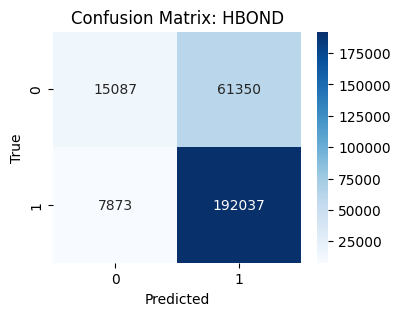

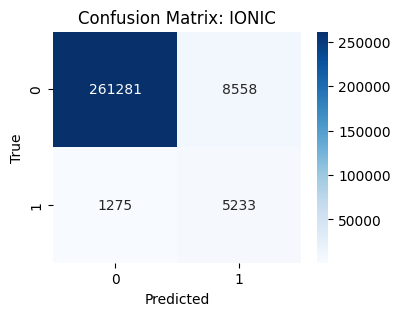

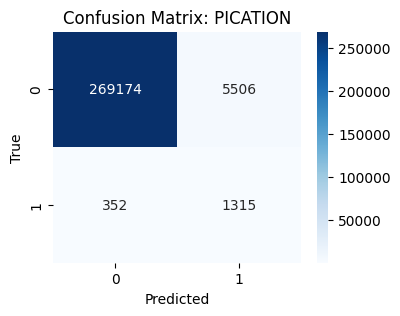

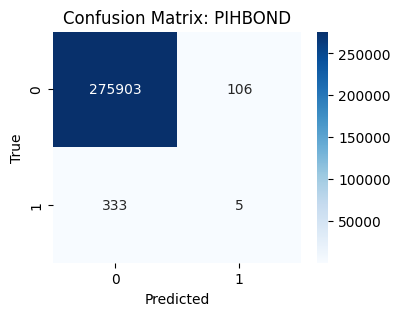

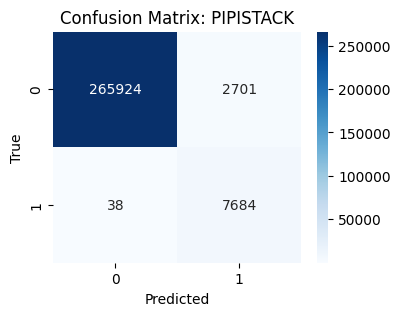

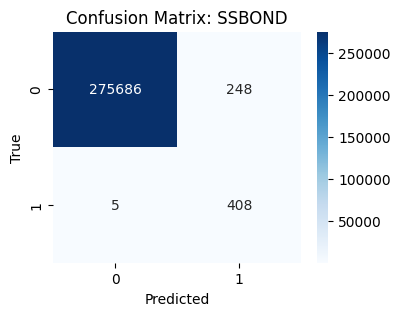

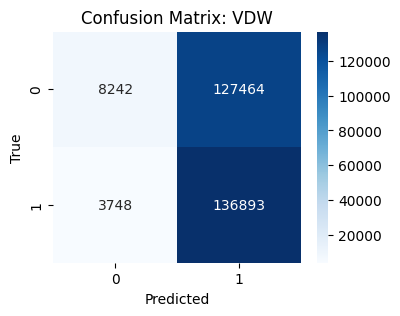

--------------------------------------------------
Plotting Co-occurrence Matrix...


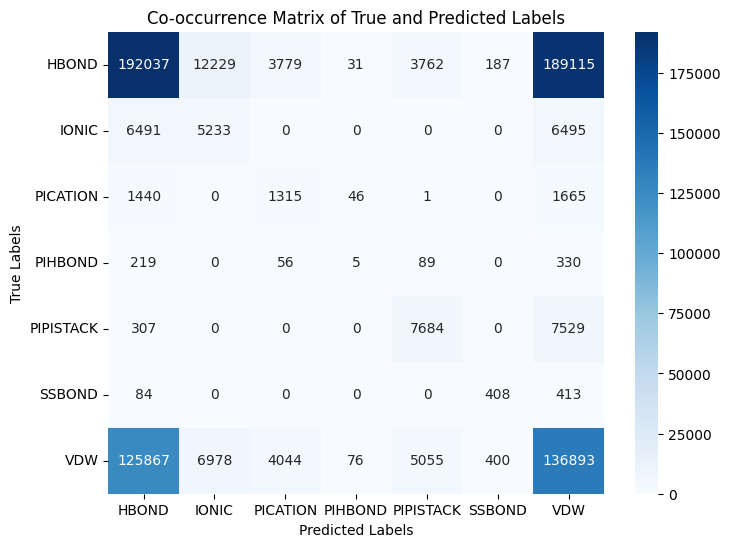

In [ ]:
# Metrics
evaluate_multilabel_model(model, test_dataset, target_cols, thresholds)

# Integrated data


## Data loading



In [ ]:
del train_dataset, val_dataset, test_dataset

In [ ]:
# Set folder name
folder_data = "/content/drive/MyDrive/Structural Bioinfo PROJECT/datasets"

# Set filenames dictionary
filenames = {'train': 'train_set_new', 'test': 'test_set_new', 'val': 'val_set_new'}

# Specify target columns
target_cols = ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

# Specify continuos columns
continuous_cols = [
    's_resi', 's_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
    't_resi', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5',
    'delta_rsa', 'delta_atchley_1', 'delta_atchley_2', 'delta_atchley_3', 'delta_atchley_4', 'delta_atchley_5',
    'ca_distance', 's_centroid_x', 's_centroid_y', 't_centroid_x', 't_centroid_y'
]

# Batch size
BATCH_SIZE = 512

# Create datasets
train_dataset, val_dataset, test_dataset, n_features, n_labels, y_val, y_test = prepare_data_for_model(
    folder_data, filenames, target_cols, continuous_cols, BATCH_SIZE, model_name="newdata_multilabel"
)

Scaler saved to: /content/drive/MyDrive/Structural Bioinfo PROJECT/datasets/newdata_multilabel_scaler.pkl
Number of features: 88
Number of labels: 7


## Model definition: Trial 2

In [ ]:
# Define the model
model_newdata = models.Sequential([
    layers.Input(shape=(n_features,)),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-2)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-2)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-2)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(n_labels, activation='sigmoid')  # multilabel output
])

model_newdata.compile(
    optimizer='adam',
    loss=SigmoidFocalCrossEntropy(gamma=1.0, alpha=0.25, reduction='sum_over_batch_size'),  # tune gamma, alpha
    metrics=[
        'binary_accuracy',  # Better for multilabel: thresholded per label
        F1Score(name='f1_score'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='AUC'),
    ]
)

## Training and testing

In [ ]:
# Train
history = model_newdata.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler],
    shuffle=True
)

Epoch 1/15
1750/1750 [==============================] - 29s 15ms/step - loss: 0.5390 - binary_accuracy: 0.8730 - f1_score: 0.2677 - precision: 0.7759 - recall: 0.4403 - AUC: 0.9422 - val_loss: 0.2993 - val_binary_accuracy: 0.8778 - val_f1_score: 0.3368 - val_precision: 0.8677 - val_recall: 0.4002 - val_AUC: 0.9609 - lr: 0.0010
Epoch 2/15
1750/1750 [==============================] - 28s 16ms/step - loss: 0.2907 - binary_accuracy: 0.8873 - f1_score: 0.3152 - precision: 0.8728 - recall: 0.4567 - AUC: 0.9635 - val_loss: 0.2888 - val_binary_accuracy: 0.8814 - val_f1_score: 0.3667 - val_precision: 0.8865 - val_recall: 0.4114 - val_AUC: 0.9646 - lr: 0.0010
Epoch 3/15
1750/1750 [==============================] - 26s 15ms/step - loss: 0.2841 - binary_accuracy: 0.8885 - f1_score: 0.3153 - precision: 0.8770 - recall: 0.4616 - AUC: 0.9645 - val_loss: 0.2813 - val_binary_accuracy: 0.8841 - val_f1_score: 0.3017 - val_precision: 0.8835 - val_recall: 0.4300 - val_AUC: 0.9655 - lr: 0.0010
Epoch 4/15
17

In [ ]:
model_newdata.save(f'{folder_data}/newdata_multilabel.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_loss, test_accuracy, test_f1_score, test_precision, test_recall, test_auc = model_newdata.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
for label_idx, label_name in enumerate(target_cols):
    print(f"{label_name} F1 Score: {test_f1_score[label_idx]:.4f}")

532/532 [==============================] - 2s 4ms/step - loss: 0.2515 - binary_accuracy: 0.8963 - f1_score: 0.3030 - precision: 0.8989 - recall: 0.4944 - AUC: 0.9708
Test Loss: 0.2515
Test Accuracy: 0.8963
Test Precision: 0.8989
Test Recall: 0.4944
HBOND F1 Score: 0.8668
IONIC F1 Score: 0.0028
PICATION F1 Score: 0.0000
PIHBOND F1 Score: 0.0000
PIPISTACK F1 Score: 0.7381
SSBOND F1 Score: 0.0067
VDW F1 Score: 0.5065


## Performance

In [ ]:
# Get thresholds
thresholds = compute_best_thresholds(model_newdata, val_dataset, target_cols, f1_score)

HBOND Threshold: 0.3000
IONIC Threshold: 0.3000
PICATION Threshold: 0.1000
PIHBOND Threshold: 0.5000
PIPISTACK Threshold: 0.2000
SSBOND Threshold: 0.2500
VDW Threshold: 0.3000


Classification Report:
              precision    recall  f1-score   support

       HBOND       0.81      0.95      0.88    197013
       IONIC       0.50      0.62      0.55      6395
    PICATION       0.22      0.65      0.33      1733
     PIHBOND       0.00      0.00      0.00       350
   PIPISTACK       0.75      0.98      0.85      7485
      SSBOND       0.67      0.87      0.75       293
         VDW       0.60      0.80      0.69    138547

   micro avg       0.71      0.88      0.79    351816
   macro avg       0.51      0.70      0.58    351816
weighted avg       0.72      0.88      0.79    351816
 samples avg       0.76      0.91      0.79    351816

--------------------------------------------------
Numerical Metrics:
F1 micro: 0.7881
F1 macro: 0.5792
Precision (macro): 0.5077
AP (macro): 0.5628
Recall (macro): 0.6956
ROC AUC Score (macro): 0.9179
MCC (mean): 0.4680
Accuracy: 0.4553
Balanced accuracy (mean): 0.7651
Hamming Loss: 0.0878
----------------------------------

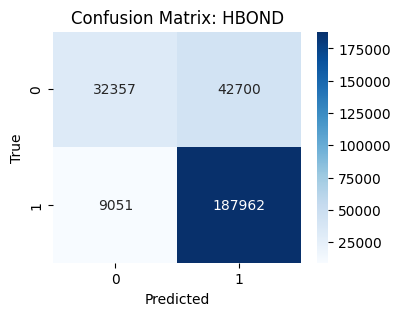

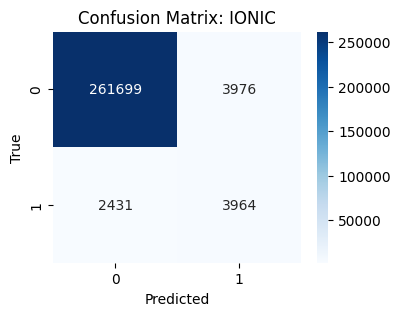

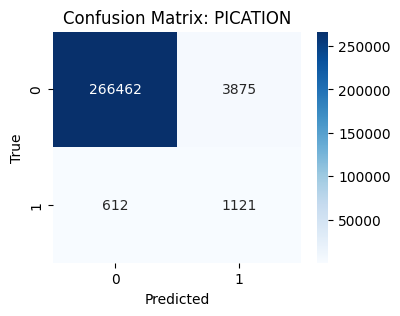

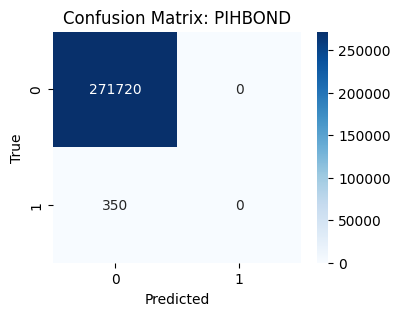

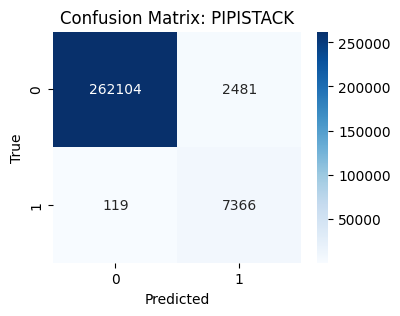

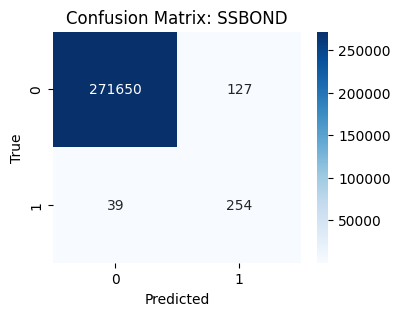

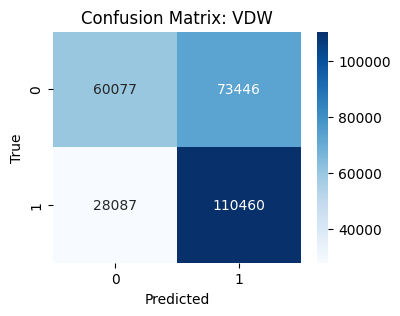

--------------------------------------------------
Plotting Co-occurrence Matrix...


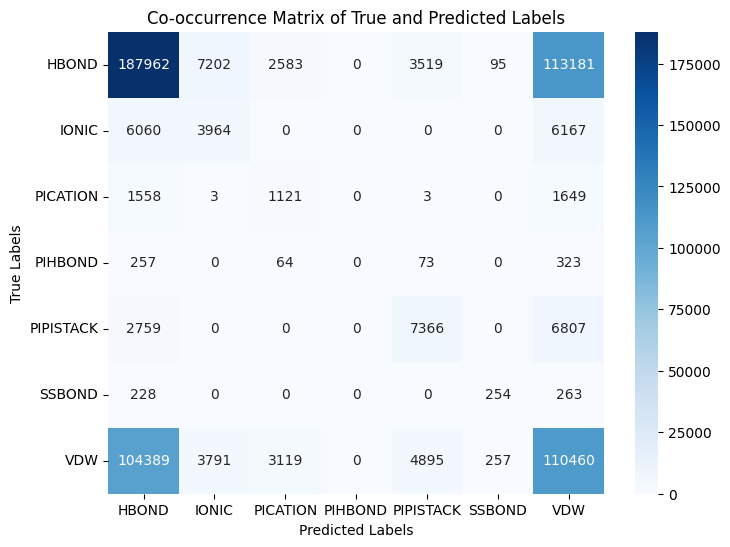

In [ ]:
# Metrics
evaluate_multilabel_model(model_newdata, test_dataset, target_cols, thresholds)

# Model on subset of features

## Data loading

In [ ]:
del train_dataset, val_dataset, test_dataset

In [ ]:
# Set folder name
folder_data = "/content/drive/MyDrive/Structural Bioinfo PROJECT/datasets"

# Set filenames dictionary
filenames = {'train': 'train_set_new', 'test': 'test_set_new', 'val': 'val_set_new'}

# Specify target columns
target_cols = ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

# Specify continuos columns
continuous_cols = [
    's_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
    't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5',
    'ca_distance', 's_centroid_x', 's_centroid_y', 't_centroid_x', 't_centroid_y'
]

# Batch size
BATCH_SIZE = 512

# Drop columns
dropped_cols = ['s_resi', 't_resi', 'delta_rsa', 'delta_atchley_1', 'delta_atchley_2',
                'delta_atchley_3', 'delta_atchley_4', 'delta_atchley_5' ]

# Create datasets
train_dataset, val_dataset, test_dataset, n_features, n_labels, y_val, y_test = prepare_data_for_model(
    folder_data, filenames, target_cols, continuous_cols, BATCH_SIZE, dropped_cols, model_name="shrinked_multilabel"
)

Scaler saved to: /content/drive/MyDrive/Structural Bioinfo PROJECT/datasets/shrinked_multilabel_scaler.pkl
Number of features: 80
Number of labels: 7


## Model definition: Trial 3

In [ ]:
# Define the model
model_shrink = models.Sequential([
    layers.Input(shape=(n_features,)),

    layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Dense(n_labels, activation='sigmoid')  # multilabel output
])

# Compile
model_shrink.compile(
    optimizer='adam',
    loss=SigmoidFocalCrossEntropy(gamma=1.0, alpha=0.25, reduction='sum_over_batch_size'),  # tune gamma, alpha
     metrics=[
        'binary_accuracy',  # Better for multilabel: thresholded per label
        F1Score(name='f1_score'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='AUC'),
    ]
)

## Training and testing


In [ ]:
# Train
history = model_shrink.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler],
    shuffle=True
)

Epoch 1/15
1750/1750 [==============================] - 30s 15ms/step - loss: 0.4734 - binary_accuracy: 0.8656 - f1_score: 0.2368 - precision: 0.7374 - recall: 0.4241 - AUC: 0.9301 - val_loss: 0.2857 - val_binary_accuracy: 0.8782 - val_f1_score: 0.2920 - val_precision: 0.8613 - val_recall: 0.4066 - val_AUC: 0.9616 - lr: 0.0010
Epoch 2/15
1750/1750 [==============================] - 27s 15ms/step - loss: 0.2712 - binary_accuracy: 0.8922 - f1_score: 0.3054 - precision: 0.8854 - recall: 0.4785 - AUC: 0.9665 - val_loss: 0.2689 - val_binary_accuracy: 0.8866 - val_f1_score: 0.3107 - val_precision: 0.8883 - val_recall: 0.4426 - val_AUC: 0.9668 - lr: 0.0010
Epoch 3/15
1750/1750 [==============================] - 28s 16ms/step - loss: 0.2667 - binary_accuracy: 0.8930 - f1_score: 0.3180 - precision: 0.8884 - recall: 0.4819 - AUC: 0.9675 - val_loss: 0.2583 - val_binary_accuracy: 0.8914 - val_f1_score: 0.3141 - val_precision: 0.9049 - val_recall: 0.4612 - val_AUC: 0.9700 - lr: 0.0010
Epoch 4/15
17

In [ ]:
model_shrink.save(f'{folder_data}/shrinked_multilabel.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_loss, test_accuracy, test_f1_score, test_precision, test_recall, test_auc = model_shrink.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
for label_idx, label_name in enumerate(target_cols):
    print(f"{label_name} F1 Score: {test_f1_score[label_idx]:.4f}")

532/532 [==============================] - 2s 4ms/step - loss: 0.2365 - binary_accuracy: 0.9015 - f1_score: 0.3239 - precision: 0.9162 - recall: 0.5137 - AUC: 0.9738
Test Loss: 0.2365
Test Accuracy: 0.9015
Test Precision: 0.9162
Test Recall: 0.5137
Test AUC: 0.9738
HBOND F1 Score: 0.8781
IONIC F1 Score: 0.0000
PICATION F1 Score: 0.0000
PIHBOND F1 Score: 0.0000
PIPISTACK F1 Score: 0.8307
SSBOND F1 Score: 0.0519
VDW F1 Score: 0.5067


## Performance

In [ ]:
# Get thresholds
thresholds = compute_best_thresholds(model_shrink, val_dataset, target_cols, f1_score)

HBOND Threshold: 0.3000
IONIC Threshold: 0.2500
PICATION Threshold: 0.1500
PIHBOND Threshold: 0.0500
PIPISTACK Threshold: 0.2000
SSBOND Threshold: 0.2500
VDW Threshold: 0.3000


Classification Report:
              precision    recall  f1-score   support

       HBOND       0.83      0.96      0.89    197013
       IONIC       0.49      0.70      0.58      6395
    PICATION       0.28      0.72      0.40      1733
     PIHBOND       0.01      0.01      0.01       350
   PIPISTACK       0.74      1.00      0.85      7485
      SSBOND       0.62      0.97      0.76       293
         VDW       0.59      0.85      0.70    138547

   micro avg       0.71      0.91      0.80    351816
   macro avg       0.51      0.75      0.60    351816
weighted avg       0.72      0.91      0.80    351816
 samples avg       0.76      0.93      0.80    351816

--------------------------------------------------
Numerical Metrics:
F1 micro: 0.7963
F1 macro: 0.5986
Precision (macro): 0.5096
AP (macro): 0.5926
Recall (macro): 0.7453
ROC AUC Score (macro): 0.9251
MCC (mean): 0.4945
Accuracy: 0.4571
Balanced accuracy (mean): 0.7884
Hamming Loss: 0.0860
----------------------------------

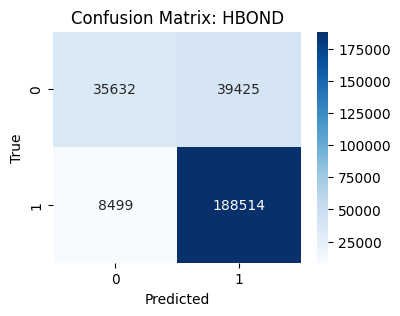

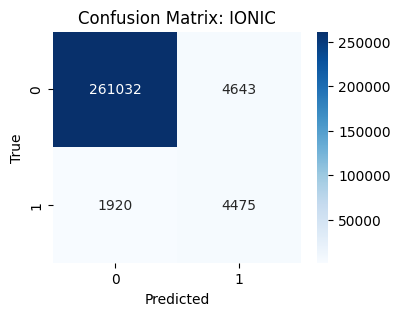

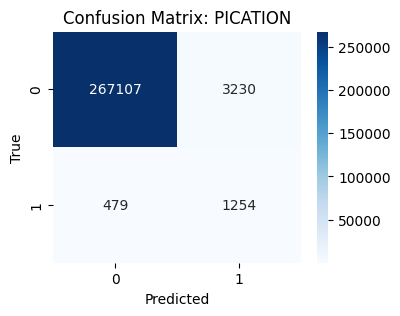

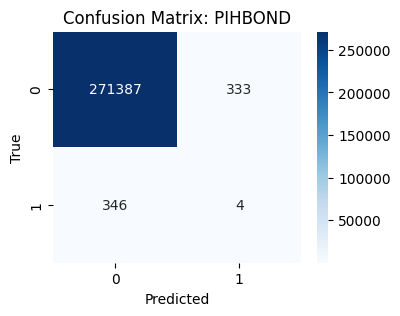

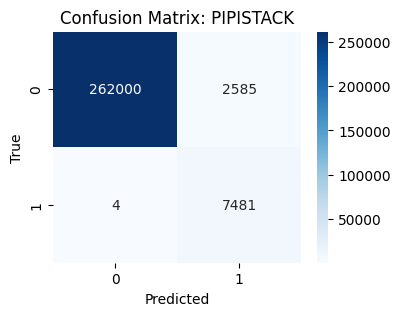

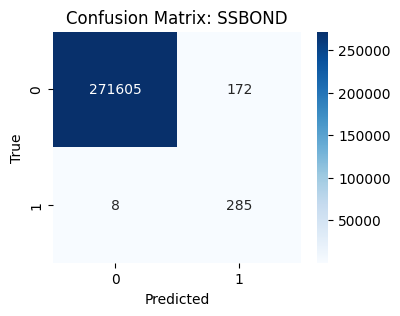

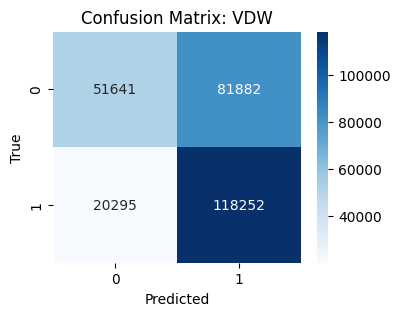

--------------------------------------------------
Plotting Co-occurrence Matrix...


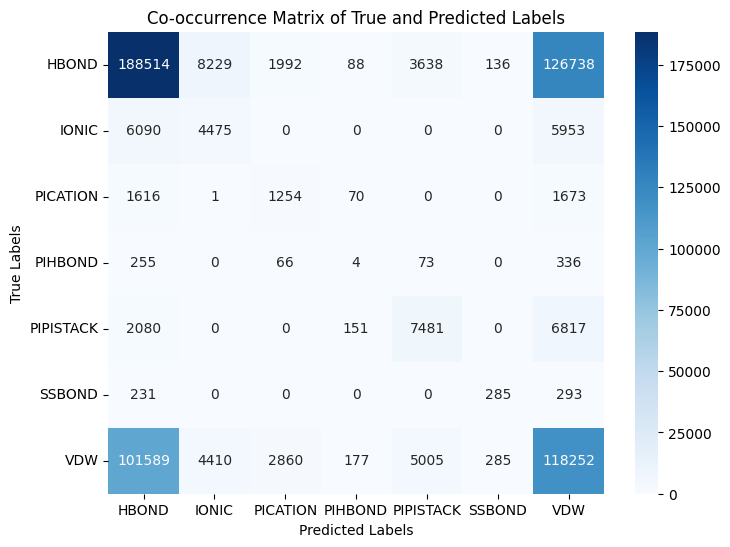

In [ ]:
# Metrics
evaluate_multilabel_model(model_shrink, test_dataset, target_cols, thresholds)